In [94]:
import sys
import os
import importlib # Used during testing if I need to reload modules

import matplotlib.pyplot as plt
import numpy as np
import cv2
import scipy.stats
import scipy.signal
import pandas as pd

In [95]:
try:
    import ngif_romar.tools as tools
    import ngif_romar.plots.make_plots as plots
    import ngif_romar.plots.plots_tools as plots_tools
except ModuleNotFoundError as error:
    # If not in path/installed, use relative import
    module_path = os.path.abspath(os.path.join("."))
    sys.path.append(module_path)
    import ngif_romar.tools as tools
#    import ngif_romar.plots.make_plots as plots
#    import ngif_romar.plots.plots_tools as plots_tools

In [96]:
dataset_path = os.path.join("..", "data", "SN2", "20201001_1739_")
logfile_path = os.path.join(dataset_path, "Data.dat")
meta_dict, data_df = tools.read_data(logfile_path)
data_df = tools.post_process_log_data(data_df)

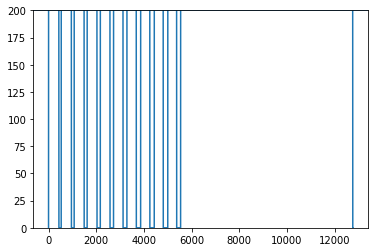

In [ ]:
plt.plot(data_df['laser_on_time(ms)'])
plt.ylim([0,200])
plt.axhline(200)

11193

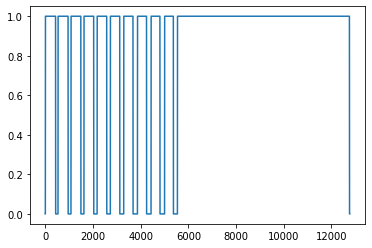

In [ ]:
plt.plot(data_df['laser_on_time(ms)'] > 200)
np.count_nonzero(data_df['laser_on_time(ms)'] > 200)

In [ ]:
from pca import pca
import numpy as np
data_df_filtered = data_df[
    data_df['laser_on_time(ms)'] > 200
]
print(len(data_df_filtered))
vals = data_df_filtered[['meltpoolSize','meltpoolTemp','flowWatch','protectionGlasTemperature']] # transpose to get column form
# columns are meltpoolSize, ..Temp, flowWatch, glasTemp

11193


In [ ]:
vals

,meltpoolSize,meltpoolTemp,flowWatch,protectionGlasTemperature
3,7931,1712.0,2860,18.6
4,7993,1714.0,2920,18.6
5,7673,1710.0,2920,18.6
6,8032,1710.0,2920,18.6
7,8245,1727.0,2920,18.6
...,...,...,...,...
12754,9621,1746.0,2752,39.0
12755,9436,1754.0,2752,39.0
12756,9548,1738.0,2752,39.0
12757,9493,1724.0,2752,39.0


In [ ]:
model = pca(alpha=0.5) # alpha = threshold for outliers in t2 test
out = model.fit_transform(vals)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [4] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [1] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.50] and n_components=[1]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


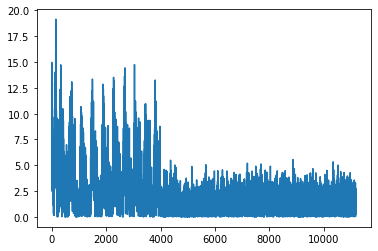

In [ ]:
plt.plot(out['outliers']['y_score'].values)